In [1]:
import copy
import torch
import time
import os

import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from def_model import EarthquakeCNN

import functions

In [2]:
class EarthquakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
datadir = './data_QSIS_pth'

train_data_path = os.path.join(datadir, "all_merged.pth")
train_data = torch.load(train_data_path)
Xall = train_data['Xall']
Yall = train_data['Yall']

In [4]:
Xall, Yall = functions.remove_small_amplitude(Xall, Yall) 
Xall, Yall = functions.remove_large_amplitude(Xall, Yall)
log10_amplitude = np.log10(np.max(np.abs(Xall), axis = (1, 2, 3)))
Xall = functions.normalize(Xall)
Xall = functions.quantize(Xall)
Xall = Xall.astype(np.float32)
Xall = functions.normalize(Xall)

In [5]:
Xall = torch.from_numpy(Xall).float()
Yall = torch.from_numpy(Yall).float()

Xall = Xall.permute(0, 3, 1, 2)

In [6]:
# split the data into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(Xall, Yall, test_size = 0.2, random_state = 42)

# create datasets
train_dataset = EarthquakeDataset(X_train, Y_train)
val_dataset = EarthquakeDataset(X_val, Y_val)

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

# put dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# similarly, create a dictionary for dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [7]:
print(X_train.shape)
print(Y_train.shape)

torch.Size([1328, 1, 80, 3])
torch.Size([1328, 3])


In [8]:
class MyModel:
    def __init__(self, model, epoch_arr, train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr, lr_arr, cm, best_acc):
        self.model = model
        self.epoch_arr = epoch_arr
        self.train_loss_arr = train_loss_arr
        self.val_loss_arr = val_loss_arr
        self.train_acc_arr = train_acc_arr
        self.val_acc_arr = val_acc_arr
        self.lr_arr = lr_arr
        self.cm = cm
        self.best_acc = best_acc


In [9]:
def plot_loss_with_MyModel(MyModel_here, plot_title = "Default"):
    epoch_arr_here = MyModel_here.epoch_arr
    train_loss_arr_here = MyModel_here.train_loss_arr
    val_loss_arr_here = MyModel_here.val_loss_arr
    train_acc_arr_here = MyModel_here.train_acc_arr
    val_acc_arr_here = MyModel_here.val_acc_arr
    lr_arr_here = MyModel_here.lr_arr

    fig_loss_func, axes_loss_func = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 6))
    fig_loss_func.suptitle(plot_title)

    axes_loss_func[0].plot(epoch_arr_here, train_loss_arr_here, label = 'Training Loss')
    axes_loss_func[0].plot(epoch_arr_here, val_loss_arr_here, label = 'Validation Loss')
    axes_loss_func[0].set_title('Loss')
    axes_loss_func[0].set_xlabel('Epoch')
    axes_loss_func[0].set_ylabel('Loss')
    axes_loss_func[0].legend()
    axes_loss_func[1].plot(epoch_arr_here, train_acc_arr_here, label = 'Training Accuracy')
    axes_loss_func[1].plot(epoch_arr_here, val_acc_arr_here, label = 'Validation Accuracy')
    axes_loss_func[1].set_title('Accuracy')
    axes_loss_func[1].set_xlabel('Epoch')
    axes_loss_func[1].set_ylabel('Accurracy')
    axes_loss_func[1].legend()
    axes_loss_func[2].plot(epoch_arr_here, lr_arr_here, label = 'Learning Rate')
    axes_loss_func[2].set_title('Learning Rate')
    axes_loss_func[2].set_xlabel('Epoch')
    axes_loss_func[2].set_ylabel('Accuracy')
    axes_loss_func[2].legend()
    fig_loss_func.tight_layout()
    plt.savefig('./Result_Finetuing/Accurracy.pdf')

In [10]:
def plot_cm_with_MyModel(MyModel_here, plot_title = "Default"):

    cm_here = MyModel_here.cm
    cm_here = cm_here.astype('float') / cm_here.sum(axis = 1)[:, np.newaxis]

    labels = ['P-wave', 'S-wave', 'Noise']
    cm_here_df = pd.DataFrame(cm_here, index = labels, columns = labels)
    cm_here = cm_here_df

    fig_cm_func, axes_cm_func = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))
    acc_here = MyModel_here.best_acc.detach().cpu().numpy() * 100
    acc_here = round(acc_here, 2)
    fig_cm_func.suptitle(plot_title + ' Confusion Matrix, Accuracy = ' + str(acc_here) + '%')

    sns.heatmap(cm_here, annot = True, cmap = 'Blues', ax = axes_cm_func)
    axes_cm_func.set_title('Train Confusion Matrix')
    axes_cm_func.set_xlabel('Predicted Labels')
    axes_cm_func.set_ylabel('Actual Labels')
    fig_cm_func.tight_layout()

    plt.savefig('./Result_Finetuing/Confusion_Matrix.pdf')

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_arr = np.array([])
    lr_arr = np.array([])
    train_loss_arr = np.array([])
    train_acc_arr = np.array([])

    val_loss_arr = np.array([])
    val_acc_arr = np.array([])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # These lists will hold all labels and predictions for this epoch
            # all_labels = []
            # all_preds = []

            all_labels = np.array([])
            all_preds = np.array([])

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs
                labels = labels

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    _, labels = torch.max(labels.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Add current labels and predictions to the lists
                # all_labels.extend(labels.tolist())
                # all_preds.extend(preds.tolist())

                all_labels = np.append(all_labels, labels.tolist())
                all_preds = np.append(all_preds, preds.tolist())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # After each epoch, compute and print the confusion matrix
            if phase == 'val':
                print("Confusion Matrix:")
                cm_here = confusion_matrix(all_labels, all_preds)
                print(cm_here)

            # save the loss and accurracy
            if phase == 'train':
                train_loss_arr = np.append(train_loss_arr, epoch_loss)
                train_acc_arr = np.append(train_acc_arr, epoch_acc.detach().cpu())
                lr_arr = np.append(lr_arr, optimizer.param_groups[0]['lr'])
                epoch_arr = np.append(epoch_arr, epoch)
            elif phase == 'val':
                val_loss_arr = np.append(val_loss_arr, epoch_loss)
                val_acc_arr = np.append(val_acc_arr, epoch_acc.detach().cpu())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    model_class = MyModel(model = model, 
                          epoch_arr = epoch_arr, 
                          train_loss_arr = train_loss_arr, 
                          val_loss_arr = val_loss_arr, 
                          train_acc_arr = train_acc_arr, 
                          val_acc_arr = val_acc_arr, 
                          lr_arr = lr_arr, 
                          cm = cm_here, 
                          best_acc = best_acc)

    return model_class

In [12]:
model = torch.load('./model/EarthquakeCNN.pth')
# model = EarthquakeCNN()

# 凍結模型的卷積層
for param in model.parameters():
    # param.requires_grad = False
    param.requires_grad = True

# 全連接層的權重將被更新
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.fc3.parameters():
    param.requires_grad = True

In [13]:
criterion = nn.CrossEntropyLoss()

# 使用Adam優化器，並且設定學習率為0.001
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
# optimizer = optim.RAdam(model.parameters(), lr = 0.001)

# 每7個epoch，學習率減半
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.5)

In [14]:
finetuned_MyModel = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------
train Loss: 1.6827 Acc: 0.4571
val Loss: 0.8646 Acc: 0.5392
Confusion Matrix:
[[49 34 20]
 [42 43 13]
 [31 13 87]]
Epoch 1/99
----------
train Loss: 0.8485 Acc: 0.5678
val Loss: 0.7648 Acc: 0.6084
Confusion Matrix:
[[ 37  46  20]
 [ 25  55  18]
 [  5  16 110]]
Epoch 2/99
----------
train Loss: 0.7595 Acc: 0.6295
val Loss: 0.6897 Acc: 0.6476
Confusion Matrix:
[[ 40  45  18]
 [ 35  51  12]
 [  7   0 124]]
Epoch 3/99
----------
train Loss: 0.6958 Acc: 0.6627
val Loss: 0.6478 Acc: 0.6898
Confusion Matrix:
[[ 51  37  15]
 [ 35  55   8]
 [  8   0 123]]
Epoch 4/99
----------
train Loss: 0.6598 Acc: 0.6852
val Loss: 0.6163 Acc: 0.6747
Confusion Matrix:
[[ 47  36  20]
 [ 38  52   8]
 [  5   1 125]]
Epoch 5/99
----------
train Loss: 0.5974 Acc: 0.7093
val Loss: 0.5892 Acc: 0.7139
Confusion Matrix:
[[ 60  33  10]
 [ 37  57   4]
 [  7   4 120]]
Epoch 6/99
----------
train Loss: 0.5725 Acc: 0.7206
val Loss: 0.5856 Acc: 0.7108
Confusion Matrix:
[[ 57  31  15]
 [ 36  54   8]
 [ 

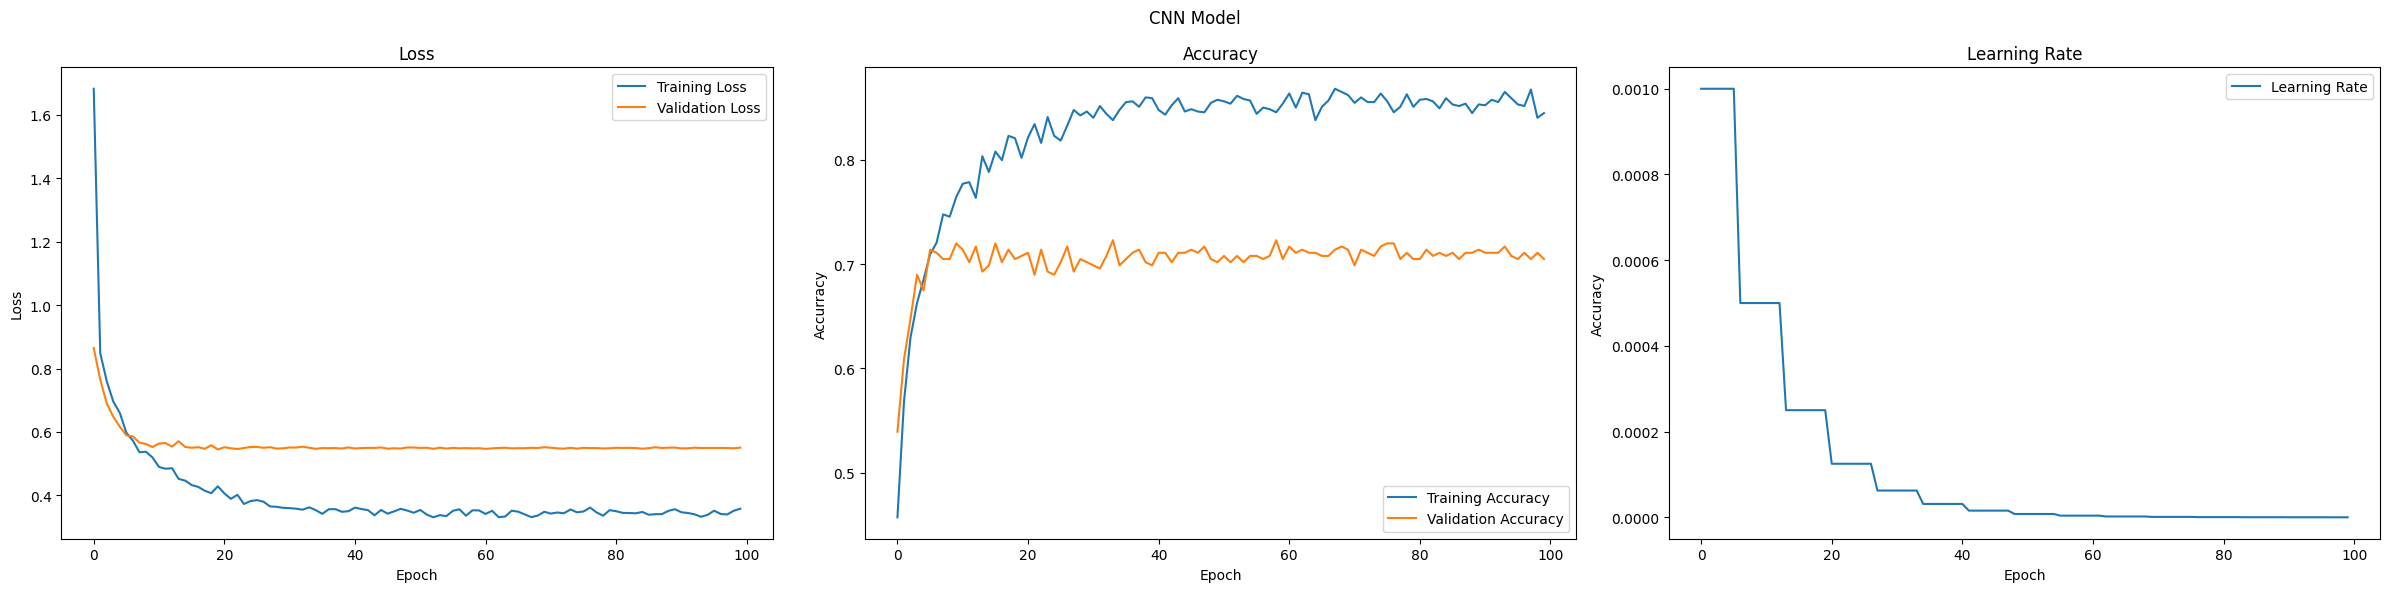

In [15]:
plot_loss_with_MyModel(finetuned_MyModel, plot_title = "CNN Model")

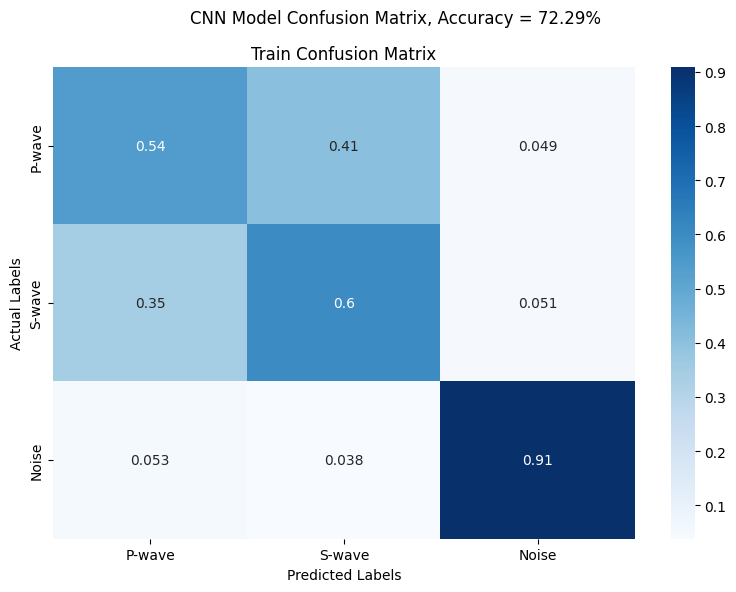

In [16]:
plot_cm_with_MyModel(MyModel_here = finetuned_MyModel, plot_title = "CNN Model")

In [17]:
torch.save(finetuned_MyModel.model, './model/EarthquakeCNN_finetuned.pth')